## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Step 2: Load the Dataset

In [2]:
file_path = r"D:\My Work\Data science\Customer Segmentation\Online Retail.xlsx"
df = pd.read_excel(file_path)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Step 3: Understand the Dataset Structure

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


## Step 4: Select Relevant Columns

In [20]:
df = df[['InvoiceNo', 'StockCode', 'Description',
         'Quantity', 'InvoiceDate', 'UnitPrice',
         'CustomerID', 'Country']]

## Step 5: Handle Missing Values

Customer segmentation is not possible without a Customer ID.

In [21]:
df = df.dropna(subset=['CustomerID'])

## Step 6: Fix Data Types

In [22]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Step 7: Remove Invalid Transactions

Negative quantity or price indicates returned or invalid orders.

In [23]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

## Step 8: Create Total Transaction Value

In [24]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

## Step 9: Define Snapshot Date

Used to calculate customer recency.

In [25]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

## Step 10: Build the RFM Table

In [26]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Step 11: Rename RFM Columns

In [27]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

## Step 12: Calculate RFM Scores (Quintiles)

In [29]:
rfm['R_score'] = pd.qcut(
    rfm['Recency'].rank(method='first'),
    5,
    labels=[5,4,3,2,1]
)

rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)

rfm['M_score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)


# Step 13: Create Combined RFM Score

In [33]:
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

# Step 14: Define Customer Segments

In [36]:
def segment_customer(row):
    if row['R_score'] >= 4 and row['F_score'] >= 4:
        return 'Loyal Customers'
    elif row['R_score'] >= 4 and row['F_score'] <= 2:
        return 'New Customers'
    elif row['R_score'] <= 2 and row['F_score'] >= 4:
        return 'At Risk Customers'
    else:
        return 'Regular Customers'

In [37]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [38]:
rfm[['R_score', 'F_score', 'M_score']].dtypes


R_score    int64
F_score    int64
M_score    int64
dtype: object

# Step 15: Segment Distribution

In [39]:
rfm['Segment'].value_counts()


Segment
Regular Customers    2622
Loyal Customers      1121
New Customers         310
At Risk Customers     285
Name: count, dtype: int64

# Step 16: Visualize Customer Segments

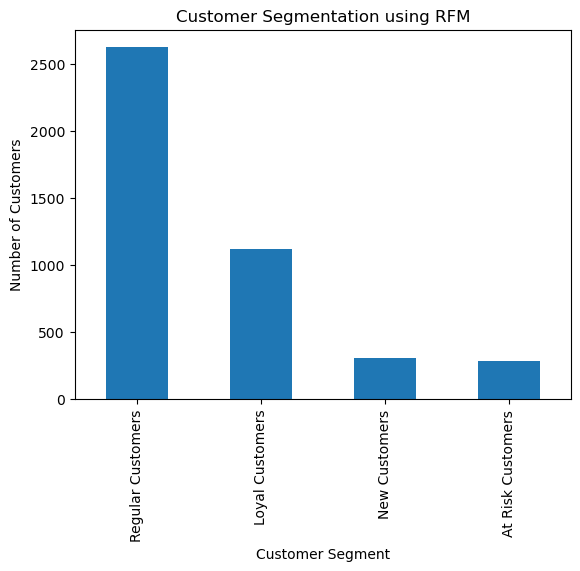

In [40]:
rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segmentation using RFM")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()


# Step 17: Export Final Dataset

In [45]:
rfm.to_csv(
    r"D:\My Work\Data science\Customer Segmentation\Customer_Segmentation_RFM.csv",
    index=False
)